#### For some actions, you may want to require human approval before running to ensure that everything is running as intended.

In [92]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [93]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [94]:
llm.invoke("hi")

AIMessage(content='Hello! 👋  How can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 10, 'total_tokens': 24, 'completion_time': 0.025454545, 'prompt_time': 3.9e-07, 'queue_time': 0.020031796, 'total_time': 0.025454935}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-e177460b-748e-4c60-9f9c-e1d0e138a7cf-0', usage_metadata={'input_tokens': 10, 'output_tokens': 14, 'total_tokens': 24})

In [95]:
llm.invoke("hi").content

'Hello! 👋  How can I help you today?\n'

In [96]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [97]:
multiply({"first_number":24,"second_number":364})

C:\Users\sunny\AppData\Local\Temp\ipykernel_55592\2089873997.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [98]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [99]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [100]:
search("who is a current president of USA?")

[{'url': 'https://simple.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is also the head of the executive branch of the federal government of the United States and is the chairman of the presidential cabinet.[10]\nJoe Biden is the 46th and current president of the United States, in office since January 2021.[11]\nEligibility and requirements[change | change source]\nArticle II, Section 1, Clause 5 of the constitution states for a person to serve as president must:\nElection process and presidential terms[change | change source]\nThe president is elected by the people through the Electoral College to a four-year term, along with the vice presidential candidate or the incumbent vice president of the United States as their running mate.[12] Contents\nPresident of the United States\nThe president of the United States (POTUS)[9] is the head of state and head of government of the United States of America and the commander-in-chief of the United States Armed F

In [101]:
search.invoke("who is a current president of USA?")

[{'url': 'https://simple.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is also the head of the executive branch of the federal government of the United States and is the chairman of the presidential cabinet.[10]\nJoe Biden is the 46th and current president of the United States, in office since January 2021.[11]\nEligibility and requirements[change | change source]\nArticle II, Section 1, Clause 5 of the constitution states for a person to serve as president must:\nElection process and presidential terms[change | change source]\nThe president is elected by the people through the Electoral College to a four-year term, along with the vice presidential candidate or the incumbent vice president of the United States as their running mate.[12] Contents\nPresident of the United States\nThe president of the United States (POTUS)[9] is the head of state and head of government of the United States of America and the commander-in-chief of the United States Armed F

In [103]:
tools=[search,multiply]

In [104]:
model_with_tools = llm.bind_tools(tools)

In [117]:
tool_mapping={tool.name: tool for tool in tools}

In [118]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000011D1D908CA0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000011D1D909870>)}

In [119]:
response = model_with_tools.invoke("who is a current president of USA?")

In [120]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j29h', 'function': {'arguments': '{"query":"Who is the current president of the USA?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.034321225, 'queue_time': 0.003081050000000002, 'total_time': 0.190684861}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d42ca288-7f30-452a-808d-2b11b24f7477-0', tool_calls=[{'name': 'search', 'args': {'query': 'Who is the current president of the USA?'}, 'id': 'call_j29h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162})

In [121]:
tool_details=response.additional_kwargs.get("tool_calls")

In [122]:
tool_details

[{'id': 'call_j29h',
  'function': {'arguments': '{"query":"Who is the current president of the USA?"}',
   'name': 'search'},
  'type': 'function'}]

In [123]:
tool_details[0]["function"]["name"]

'search'

In [124]:
tool_details[0]["function"]["arguments"]

'{"query":"Who is the current president of the USA?"}'

In [125]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'Who is the current president of the USA?'}

In [126]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'url': 'https://en.wikipedia.org/wiki/Presidency_of_Joe_Biden',
  'content': 'On November 23, after Michigan certified its results, Murphy issued the letter of ascertainment, granting the Biden transition team access to federal funds and resources for an orderly transition.[29]\nTwo days after becoming the projected winner of the 2020 election, Biden announced the formation of a task force to advise him on the COVID-19 pandemic during the transition, co-chaired by former Surgeon General Vivek Murthy, former FDA commissioner David A. Kessler, and Yale University\'s Marcella Nunez-Smith.[30]\nOn January 5, 2021, the Democratic Party won control of the United States Senate, effective January 20, as a result of electoral victories in Georgia by Jon Ossoff in a runoff election for a six-year term and Raphael Warnock in a special runoff election for a two-year term.[31][32] President-elect Biden had supported and campaigned for both candidates prior to the runoff elections on January 5.[33

In [127]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [128]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [130]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [131]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [132]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [133]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [134]:
app = graph.compile()

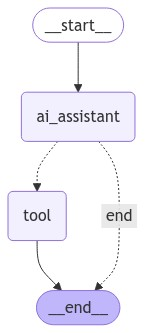

In [135]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [136]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r1es', 'function': {'arguments': '{"query":"who is the upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1075, 'total_tokens': 1161, 'completion_time': 0.156363636, 'prompt_time': 0.058229979, 'queue_time': 0.002707053000000001, 'total_time': 0.214593615}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9509165a-ce6a-4153-a13b-ef298f605b04-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the upcoming president of USA'}, 'id': 'call_r1es', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 86, 'total_tokens': 1161})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.cnn.com/interactive/2024/politics/presidential-candidates-dg/', 'content': '2024 Presidential Candidates. By CNN S

In [137]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6219', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1080, 'total_tokens': 1173, 'completion_time': 0.169090909, 'prompt_time': 0.044015498, 'queue_time': 0.0026565559999999974, 'total_time': 0.213106407}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f2eaa91-7613-4d38-a9f7-4f5bce08804b-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_6219', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 93, 'total_tokens': 1173})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [138]:
for s in app.stream({"messages": ["what is the total amount of money exist over the earth?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x5n1', 'function': {'arguments': '{"query":"total amount of money exist over the earth"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1080, 'total_tokens': 1167, 'completion_time': 0.158181818, 'prompt_time': 0.034949826, 'queue_time': 0.0030261179999999943, 'total_time': 0.193131644}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ea9306f0-8c34-44d0-9cad-0cff7d1c39ac-0', tool_calls=[{'name': 'search', 'args': {'query': 'total amount of money exist over the earth'}, 'id': 'call_x5n1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 87, 'total_tokens': 1167})]}
----
Selected tool: search


Exception: web search discard

#### LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.

In [139]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [140]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [141]:
tavily=TavilySearchResults()

In [ ]:
tools = [tavily]

In [142]:
llm_with_tools = llm.bind_tools(tools)

In [143]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [144]:
memory = MemorySaver()

In [145]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [147]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [148]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

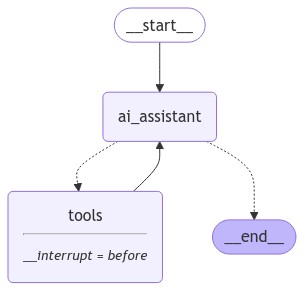

In [149]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [150]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [151]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [152]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  search (call_5pgj)
 Call ID: call_5pgj
  Args:
    query: what is the capital of india


In [153]:
snapshot = app2.get_state(config)

In [154]:
snapshot.next

('tools',)

In [155]:
last_message=snapshot.values["messages"][-1]

In [156]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'what is the capital of india'},
  'id': 'call_5pgj',
  'type': 'tool_call'}]

In [159]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [160]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_6kp1)
 Call ID: call_6kp1
  Args:
    query: what is the capital of india
================================= Tool Message =================================
Name: search

[{"url": "https://www.yahoo.com/news/capital-india-territory-came-plus-130045224.html", "content": "About 1.4 billion people live in India, and the country is predicted to top China as the world’s most populous country by mid-2023, the United Nations reports. The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Mumbai, the state capital of Maharashtra, is often considered the financial capital of India because of its role in the national and international economy. New Delhi is part of one of India’s union territories, the National Capital Territory of Dehli. This article originally appeared on USA TODAY: What is the capital of India?"}, {"url": "https

In [161]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [162]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [163]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  search (call_a0jf)
 Call ID: call_a0jf
  Args:
    query: what is the weather in new delhi


In [164]:
snapshot = app2.get_state(config)

In [165]:
snapshot.next

('tools',)

In [166]:
last_message=snapshot.values["messages"][-1]

In [167]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'what is the weather in new delhi'},
  'id': 'call_a0jf',
  'type': 'tool_call'}]

In [168]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [169]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_a0jf)
 Call ID: call_a0jf
  Args:
    query: what is the weather in new delhi
================================= Tool Message =================================
Name: search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New Delhi', 'region': 'Delhi', 'country': 'India', 'lat': 28.6, 'lon': 77.2, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1731747682, 'localtime': '2024-11-16 14:31'}, 'current': {'last_updated_epoch': 1731747600, 'last_updated': '2024-11-16 14:30', 'temp_c': 28.0, 'temp_f': 82.4, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 7.6, 'wind_kph': 12.2, 'wind_degree': 319, 'wind_dir': 'NW', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 35, 'cloud': 0, 'feelslike_c': 26.0, 'feelslike_f': 78.8, 'windchill_c': 30.2, 'w

In [170]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='010366f9-229e-4e36-8c4f-4153b6f114a4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5pgj', 'function': {'arguments': '{"query":"what is the capital of india"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1076, 'total_tokens': 1161, 'completion_time': 0.154545455, 'prompt_time': 0.045566493, 'queue_time': 0.0024469869999999977, 'total_time': 0.200111948}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2a2e08b-39e2-474e-84cb-b4946c94be02-0', tool_calls=[{'name': 'search', 'args': {'query': 'what is the capital of india'}, 'id': 'call_5pgj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 85, 'total_tokens': 1161}), ToolMessage(content='[{"

In [171]:
snapshot=app2.get_state(config)

In [172]:
snapshot.next

()

In [173]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}

In [174]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [175]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  search (call_k054)
 Call ID: call_k054
  Args:
    query: recent news new delhi


In [176]:
snapshot=app2.get_state(config)

In [177]:
current_message = snapshot.values["messages"][-1]

In [178]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_k054)
 Call ID: call_k054
  Args:
    query: recent news new delhi


In [179]:
tool_call_id = current_message.tool_calls[0]["id"] 

In [180]:
tool_call_id

'call_k054'

In [181]:
from langchain_core.messages import AIMessage, ToolMessage

In [ ]:
answer = "it is just related to raining which is happing on daily basis"

In [182]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [183]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa3f9e-a414-6c0a-800e-b3cf9a8c9199'}}

In [184]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='86ee0c6d-7771-4ed6-8bd2-242adace39be')]
